# BASELINE NOTEBOOK 

## Metrics

the following metrics will be used for the model:

`auc`= Approximates the AUC (Area under the curve) of the ROC or PR curves. (ROC / PR)

`Precision` 

`Recall `

`F1`

## general `Baseline` for data train

In [107]:
import os, folium, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v3 as iio
import geopandas as gpd
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.keras import layers, callbacks, backend, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [6]:
labels= gpd.read_file('labels.geojson')
labels_unique = labels[(labels.Type == 'Negative') | (labels.Type == 'CAFOs') | (labels.Type == 'WWTreatment')
           | (labels.Type == 'Landfills') | (labels.Type == 'RefineriesAndTerminals')
           | (labels.Type == 'ProcessingPlants') | (labels.Type == 'Mines')]

In [10]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels_unique.Type.values.reshape(labels_unique.Type.values.shape[0], 1))
mlb.classes_

array(['CAFOs', 'Landfills', 'Mines', 'Negative', 'ProcessingPlants',
       'RefineriesAndTerminals', 'WWTreatment'], dtype=object)

In [13]:
y_train, y_test= train_test_split(y, train_size=0.1, stratify=y)
def invert_ecoding(encoded_labels, categories):
    categories = ['[unk]']+categories
    return np.take(categories, np.argwhere(encoded_labels == 1.0)[:,1])
y_tra_orig = np.argwhere(y_train == 1.0)[:,1]
y_test_orig = np.argwhere(y_test == 1.0)[:,1]

In [21]:
y_test_orig

array([3, 6, 3, ..., 0, 3, 3])

In [44]:
# same probability for all the instances
constant_probability = np.full_like(y_test, 1/7)

y_pred_baseline = np.argmax(constant_probability, axis=1)

# Calculate metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_baseline)
precision = precision_score(np.argmax(y_test, axis=1), y_pred_baseline, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_baseline, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_baseline, average='weighted')
auc = roc_auc_score(y_test, constant_probability, average='weighted')


/root/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'value': [accuracy, precision, recall, f1, auc]
})

In [47]:
results_df

,Metric,value
0,Accuracy,0.289995
1,Precision,0.084097
2,Recall,0.289995
3,F1-score,0.130384
4,AUC,0.500000


## `Baseline` CNN

#### categorical model

In [94]:
##labels_unique.Image_Folder=labels_unique.Image_Folder+"/naip.png"
##separate the datasets in train and test
train = int(labels_unique.shape[0] * 0.8)
test = int(labels_unique.shape[0] * 0.2)
labels_unique_train = labels_unique.iloc[:train, :]
labels_unique_test = labels_unique.iloc[train:, :]

In [111]:
##input data 
image_size = (720, 720)
batch_size = 64
validation_split = 0.2
test_split = 0.1

##get images from path on train and test 

from keras.preprocessing import image
dir_path=r"/root/code/dvictoria2/methane_source/"
train_datagen=image.ImageDataGenerator(rescale=1./255, validation_split = validation_split)
test_datagen =image.ImageDataGenerator(rescale=1./255)

In [112]:
##create generators for train_validation and test
train_generator=train_datagen.flow_from_dataframe(
    dataframe=labels_unique_train, directory=dir_path, 
    x_col="Image_Folder", y_col="Type", seed = 42,
    class_mode="categorical", target_size=(720,720), batch_size=batch_size , subset = "training", color_mode='rgb')
validation_generator = train_datagen.flow_from_dataframe(dataframe=labels_unique_train, directory=dir_path, 
    x_col="Image_Folder", y_col="Type", seed = 42,
    class_mode="categorical", target_size=(720,720), batch_size=batch_size/2, subset = "validation", color_mode='rgb')
test_generator = test_datagen.flow_from_dataframe(dataframe=labels_unique_test, directory=dir_path, 
    x_col="Image_Folder", y_col="Type", seed = 42,
    class_mode="categorical", target_size=(720,720), batch_size=batch_size , color_mode='rgb')

Found 9040 validated image filenames belonging to 7 classes.
Found 2260 validated image filenames belonging to 7 classes.
Found 2826 validated image filenames belonging to 7 classes.


In [113]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [116]:
##create build_model funtion
def build_model():
    inputs = layers.Input(shape=(720, 720, 3))
    res= layers.Resizing(360,360, interpolation='bilinear',
                         crop_to_aspect_ratio=False)(inputs)
    cnn = layers.Conv2D(32, (3, 3), activation='relu')(res)
    cnn2 = layers.MaxPooling2D((2, 2))(cnn)
    cnn3 = layers.Conv2D(64, (3, 3), activation='relu')(cnn2)
    cnn4 = layers.MaxPooling2D((2, 2))(cnn3)
    
    flatten = layers.Flatten()(cnn4)
    dense1 = layers.Dense(16, activation='relu')(flatten)
    out = layers.Dense(7, activation='softmax')(dense1)
    
    model = Model(inputs=inputs, outputs=out)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        'accuracy'
    ])
    return model


In [117]:
model=build_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 720, 720, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 360, 360, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 358, 358, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 179, 179, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 177, 177, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 88, 88, 64)       0         
 g2D)                                                      

In [119]:
cb = [callbacks.EarlyStopping(patience=5), callbacks.ReduceLROnPlateau(patience=3),callbacks.ModelCheckpoint('methane_V1.hdf5', monitor='loss',verbose=1, save_best_only=True)]
epochs = 20
# fits the model on batches with real-time data augmentation:
history =model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10, callbacks = cb)



/tmp/ipykernel_2730/100529573.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(generator=train_generator,


Epoch 1/10
141/141 [==============================] - ETA: 0s - loss: 1.4138 - auc: 0.8273 - pr_auc: 0.4587 - precision: 0.6157 - recall: 0.1360 - accuracy: 0.4648

2023-05-24 03:36:58.442704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 03:36:58.509290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 03:36:58.509327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 03:36:58.509340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-24 03:36:58.509349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f


Epoch 1: loss improved from inf to 1.41383, saving model to methane_V1.hdf5
141/141 [==============================] - 160s 1s/step - loss: 1.4138 - auc: 0.8273 - pr_auc: 0.4587 - precision: 0.6157 - recall: 0.1360 - accuracy: 0.4648 - val_loss: 1.3807 - val_auc: 0.8381 - val_pr_auc: 0.4874 - val_precision: 0.6112 - val_recall: 0.2281 - val_accuracy: 0.4853 - lr: 0.0010
Epoch 2/10
141/141 [==============================] - ETA: 0s - loss: 1.2490 - auc: 0.8701 - pr_auc: 0.5841 - precision: 0.7058 - recall: 0.3185 - accuracy: 0.5379
Epoch 2: loss improved from 1.41383 to 1.24897, saving model to methane_V1.hdf5
141/141 [==============================] - 151s 1s/step - loss: 1.2490 - auc: 0.8701 - pr_auc: 0.5841 - precision: 0.7058 - recall: 0.3185 - accuracy: 0.5379 - val_loss: 1.1805 - val_auc: 0.8856 - val_pr_auc: 0.6301 - val_precision: 0.6677 - val_recall: 0.3938 - val_accuracy: 0.5536 - lr: 0.0010
Epoch 3/10
141/141 [==============================] - ETA: 0s - loss: 1.1514 - auc: 0

ValueError: too many values to unpack (expected 2)

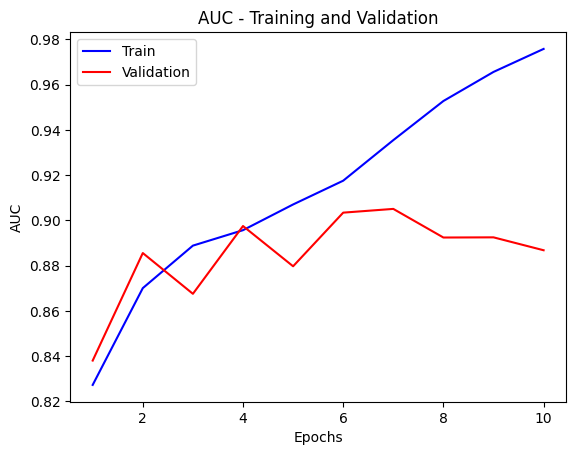

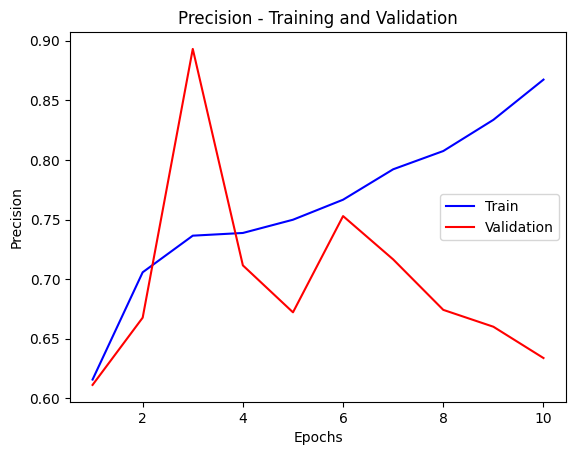

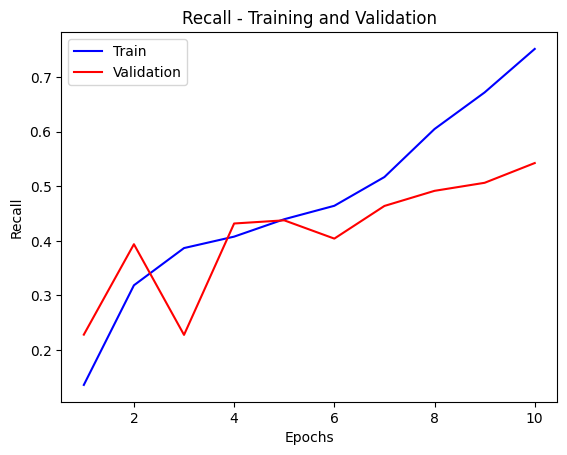

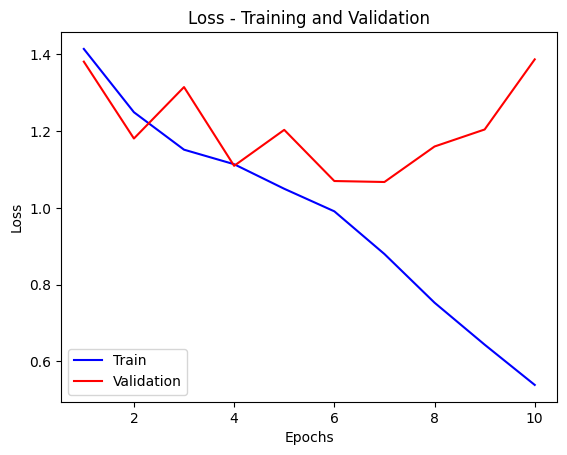

In [126]:
import matplotlib.pyplot as plt

def plot_metric(metric_name, train_values, val_values, title):
    epochs = range(1, len(train_values) + 1)
    plt.plot(epochs, train_values, 'b', label='Train')
    plt.plot(epochs, val_values, 'r', label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

def plot_metrics(history):
    # metrics
    plot_metric('AUC', history.history['auc'], history.history['val_auc'], 'AUC - Training and Validation')
    plot_metric('Precision', history.history['precision'], history.history['val_precision'], 'Precision - Training and Validation')
    plot_metric('Recall', history.history['recall'], history.history['val_recall'], 'Recall - Training and Validation')
    
    # loss
    plot_metric('Loss', history.history['loss'], history.history['val_loss'], 'Loss - Training and Validation')


plot_metrics(history)


In [121]:
# evaluate the test set
loss, auc, pr_auc, precision, recall, accuracy =model.evaluate(test_generator, steps=STEP_SIZE_TEST)

44/44 [==============================] - 40s 915ms/step - loss: 1.5389 - auc: 0.8705 - pr_auc: 0.6091 - precision: 0.6023 - recall: 0.5103 - accuracy: 0.5483


In [124]:
resu= pd.DataFrame({'metrics': ['loss', 'auc', 'pr_auc',' precision', 'recall', 'accuracy'],
                    'value': [loss, auc, pr_auc, precision, recall, accuracy]})

#### OVERALL RESULTS FOR CATEGORICAL MODEL

In [125]:
resu

,metrics,value
0,loss,1.538861
1,auc,0.870523
2,pr_auc,0.609116
3,precision,0.602263
4,recall,0.510298
5,accuracy,0.548295


### BINARY MODEL 

In [127]:
def build_model2():
    inputs = layers.Input(shape=(720, 720, 3))
    res= layers.Resizing(360,360, interpolation='bilinear',
                         crop_to_aspect_ratio=False)(inputs)
    cnn = layers.Conv2D(32, (3, 3), activation='relu')(res)
    cnn2 = layers.MaxPooling2D((2, 2))(cnn)
    cnn3 = layers.Conv2D(64, (3, 3), activation='relu')(cnn2)
    cnn4 = layers.MaxPooling2D((2, 2))(cnn3)
    
    flatten = layers.Flatten()(cnn4)
    dense1 = layers.Dense(16, activation='relu')(flatten)
    out = layers.Dense(7, activation='sigmoid')(dense1)
    
    model = Model(inputs=inputs, outputs=out)
    
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        'accuracy'
    ])
    return model

In [129]:
model2=build_model2()
model2.summary()
cb = [callbacks.EarlyStopping(patience=5), callbacks.ReduceLROnPlateau(patience=3),callbacks.ModelCheckpoint('methane_V1.hdf5', monitor='loss',verbose=1, save_best_only=True)]
epochs = 20
# fits the model on batches with real-time data augmentation:
history2 =model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10, callbacks = cb)

loss2, auc2, pr_auc2, precision2, recall2, accuracy2 =model2.evaluate(test_generator, steps=STEP_SIZE_TEST)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 720, 720, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 360, 360, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 358, 358, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 179, 179, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 177, 177, 64)      18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 88, 88, 64)       0         
 g2D)                                                      

/tmp/ipykernel_2730/4021984588.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 =model2.fit_generator(generator=train_generator,


Epoch 1/10


2023-05-24 05:08:19.635086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 05:08:19.735189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 05:08:19.735239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 05:08:19.735255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-24 05:08:19.735266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

141/141 [==============================] - ETA: 0s - loss: 0.3663 - auc: 0.8202 - pr_auc: 0.4676 - precision: 0.5959 - recall: 0.3114 - accuracy: 0.4905

2023-05-24 05:10:35.794239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-24 05:10:35.858030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 05:10:35.858069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 05:10:35.858082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-24 05:10:35.858091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f


Epoch 1: loss improved from inf to 0.36631, saving model to methane_V1.hdf5
141/141 [==============================] - 169s 1s/step - loss: 0.3663 - auc: 0.8202 - pr_auc: 0.4676 - precision: 0.5959 - recall: 0.3114 - accuracy: 0.4905 - val_loss: 0.2768 - val_auc: 0.8774 - val_pr_auc: 0.6106 - val_precision: 0.6995 - val_recall: 0.3616 - val_accuracy: 0.5549 - lr: 0.0010
Epoch 2/10
 62/141 [============>.................] - ETA: 1:12 - loss: 0.2678 - auc: 0.8850 - pr_auc: 0.6404 - precision: 0.7043 - recall: 0.3997 - accuracy: 0.5903

OVERALL RESULTS FOR BINARY MODEL